# Doc2Vec
```python3
- Word2Vec의 확장판 모델
- 기본적인 매개변수, 속성, 메서드는 Word2Vec과 같다.
```
- **매개변수**
    - <span style="color:#ffd33d">**dm**</span>
        </br>: 학습 알고리즘 선택
        - 기본값: 1
            - 0 : PT-DBOW <span style='color:#808080'>(Distributed Bag of Words)
                - 단어 벡터와 문서 벡터를 함께 사용하여 다음 단어를 예측
                - 문맥과 문서 정보를 동시에 학습하므로 정확도가 높음 (CBOW와 유사)
            - 1 : PV-DM <span style='color:#808080'>(Distributed Memory)
                - 문서 벡터만 사용하여 문맥 내의 랜덤한 단어를 예측
                - 단어 벡터는 학습하지 않거나(기본) dbow_words=1로 설정하여 함께 학습
                - 속도가 빠르고 단순함 (Skip-gram과 유사)
    - <span style="color:#ffd33d">**dm_mean**</span>
        </br>: PV-DM 사용 시 문장 벡터의 계산 방식
        - 기본값: 0
            - 0 : 벡터들의 합산
                - 범위가 커지는 경우가 발생 $\rightarrow$ 노이즈로 인한 성능 저하가 발생할 수 있음
            - 1 : 벡터들의 평균
                - 평균이 합산보다 문장 길이의 영향을 덜 받아 더 안정적
    - <span style="color:#ffd33d">**dm_concat**</span>
        </br>: PV-DM 사용 시 문서 벡터와 문장 벡터를 결합할 것인가?
        - 기본값: 0
            - 0 : 합산
            - 1 : 결합
                - 차원 급증(피쳐 $\uparrow$ $\uparrow$) $\rightarrow$ 특정 단어만 잘 맞히게 될 수 있음
                - 단어 순서 정보를 더 잘 보존
    - <span style="color:#ffd33d">**dbow_words**</span>
        </br>: PV-DBOW 사용 시 단어 벡터도 동시에 학습할 것인가?
        - Skip-gram 방식과 흡사
        - 기본값: 0
            - 1 (0이 아닐 때) : PV-DBOW와 Word2Vec의 Skip-gram 방식이 동시에 학습되어 성능 향상

- **속성**
    - <span style="color:#ffd33d">**model.wv**</span>
        </br>: 학습된 단어 벡터의 저장소 (dict 형태)
        - wv를 통해 뽑아온 특정 단어의 단위 벡터들을 저장
    - <span style="color:#ffd33d">**model.dv**</span>
        </br>: 학습된 문장 벡터의 저장소
        - Doc2Vec의 핵심 속성 (dv는 Document Vector의 약자)
        - **태그(문서 ID)** 를 키로 사용합
    - <span style="color:#ffd33d">**model.dv.index_to_key**</span>
        </br>: dv에 저장된 문서들의 ID (태그) 리스트

- **메서드**
    - <span style="color:#ffd33d">**build_vocab()**</span>
        </br>: 단어-문서 사전을 구성
    - <span style="color:#ffd33d">**train()**</span>
        </br>: 사전이 구축된 뒤 직접 학습을 수행


- ```build_vocab()```, ```train()``` 메서드를 이용해 수동 학습
    - ```gensim```의 ```Word2Vec``` / ```Doc2Vec```은 ```build_vocab()```으로 단어장/태그 사전을 먼저 구성 $\rightarrow$ ```train()```을 통해 가중치를 학습하는 2단계 수동 학습 방식을 지원
    </br> $\Rightarrow$ 증분 학습에서 필수적 (기존에 학습된 모델에 새로운 데이터셋을 추가)
    - 데이터의 양이 증가하면 성능이 증가할 수 있으나, 기존에 학습시킨 데이터와 유사한 데이터를 증분 학습해야 함

In [21]:
# gensim 라이브러리 안의 Doc2Vec를 이용하여 임베딩
from konlpy.tag import Komoran
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re
import random

In [3]:
# 샘플 데이터를 2개 유형의 문장들로 구성
docs = [
    '나는 커피를 정말 좋아한다',
    '오늘 아침에 에스프레소 두 잔을 마셨다',
    '카페라떼가 제일 맛있다고 생각한다',
    '나는 차를 더 자주 마신다',
    '녹차를 마시면 기분이 편안해진다',
    '홍차는 향이 깊고 고급스러운 느낌이다',
    '카페에서 책을 읽는 시간이 너무 좋다',
    '허브티도 몸에 좋은 거 같다'
]

In [ ]:
# 형태소 분석 (Komoran)을 사용하여 토큰화
komoran = Komoran()

# 특정 품사만 사용
allow_pos = ['NNP', 'NNG', 'VV', 'VA', 'MAG', 'XR']
# 불용어
stop_word = ['하다', '되다', '이다', '것', '수', '거']

# 문자에서 불필요한 글자들을 제거 (정규화)
def normalize(text):
    # 특수문자만 공백으로 대체 (한글, 숫자, 알파벳, 공백 제외)
    # re.sub( "A", "B" ) : A를 B로 대체
    text = re.sub( r"[^가-힣0-9a-zA-Z\s\.]", " ", text )
    # 여러 개의 공백을 하나로 합치고 앞뒤 공백 제거
    text = re.sub( r"\s+", " ", text ).strip()      # strip()으로 문자열의 좌우 공백 제거
    return text

# 토큰화 함수 정의
def tokenize(text):
    # 문자의 정규화 함수를 호출
    text = normalize(text)

    tokens = []
    for word, pos in komoran.pos(text):
        if pos in allow_pos:
            # (옵션) 길이를 체크하기 전에 동사, 형용사에는 '다' 붙이기
            if pos in ['VV', 'VA']:
                word += '다'
            if word not in stop_word and len(word) > 1:
                # allow_pos에 포함 , stop_word에 포함X , 단어의 길이 > 1 인 문자만 활용
                tokens.append(word)
    return tokens

In [ ]:
# 토큰화된 문서들
tokenized_docs = [ tokenize(doc) for doc in docs ]
tokenized_docs

[['커피', '정말', '좋아하다'],
 ['오늘', '아침', '에스프레소', '마시다'],
 ['카페', '제일', '맛있다', '생각'],
 ['자주', '마시다'],
 ['녹차', '마시다', '기분', '편안'],
 ['홍차', '깊다', '고급', '느낌'],
 ['카페', '읽다', '시간', '너무', '좋다'],
 ['허브', '좋다', '같다']]

In [ ]:
# 문장 별로 ID를 지정
tagged = []
for idx, toks in enumerate(tokenized_docs):
    # TaggedDocument를 이용하여 문장 별로 ID를 부여하고 tagged에 추가
    tagged.append(
        TaggedDocument(words= toks, tags= [f'DOC_{idx}'])
        # 단어 리스트 그대로 사용. tags를 통해 고유 식별자(DOC_1, DOC_2, ...)를 달아줌.
    )

tagged

[TaggedDocument(words=['커피', '정말', '좋아하다'], tags=['DOC_0']),
 TaggedDocument(words=['오늘', '아침', '에스프레소', '마시다'], tags=['DOC_1']),
 TaggedDocument(words=['카페', '제일', '맛있다', '생각'], tags=['DOC_2']),
 TaggedDocument(words=['자주', '마시다'], tags=['DOC_3']),
 TaggedDocument(words=['녹차', '마시다', '기분', '편안'], tags=['DOC_4']),
 TaggedDocument(words=['홍차', '깊다', '고급', '느낌'], tags=['DOC_5']),
 TaggedDocument(words=['카페', '읽다', '시간', '너무', '좋다'], tags=['DOC_6']),
 TaggedDocument(words=['허브', '좋다', '같다'], tags=['DOC_7'])]

In [ ]:
# tag를 추가한 문서를 학습 데이터로 이용해 Doc2Vec 모델에 학습
model = Doc2Vec(
    documents= tagged,
    vector_size= 120,
    window= 5,
    min_count= 1,   # 데이터의 개수가 작기 때문 (실제 3-5)
    dm= 1,          # PV-DM 방식
    dm_mean= 1,     # 벡터들의 평균 (범위를 크지 않게 잡아 안정적)
    negative= 5,    # 잘못된 단어 간의 배치를 사용하여 학습에 이용 (오답을 '오답'이라 알려줌)
    epochs= 50,
    seed= 42
)

In [ ]:
print("학습된 문장의 개수:", len(model.dv))

학습된 문장의 개수: 8


In [ ]:
# 문장 간의 유사도를 수치적으로 확인
def print_similarities(doc_id):
    dic_vec = model.dv[f"DOC_{doc_id}"]
    # doc_id: 문서의 tag 이름
    # 각 문장들의 벡터 데이터를 리스트로 생성
    mat = np.vstack(
        [ model.dv[f"DOC_{i}"] for i in range(len(docs)) ]
    )
    # 코사인 유사도 사용
    sims = cosine_similarity( [dic_vec], mat )[0]
    order = sims.argsort()[::-1]    # 내림차순 정렬
    print(f"기존의 문장: {doc_id} \n -> {docs[doc_id]}")
    for idx in order:
        print( f"    -> idx {idx}: {docs[idx]}   |   cos 유사도: {sims[idx]}")

print_similarities(0)

기존의 문장: 0 
 -> 나는 커피를 정말 좋아한다
    -> idx 0: 나는 커피를 정말 좋아한다   |   cos 유사도: 1.0
    -> idx 7: 허브티도 몸에 좋은 거 같다   |   cos 유사도: 0.1954648792743683
    -> idx 1: 오늘 아침에 에스프레소 두 잔을 마셨다   |   cos 유사도: 0.13140203058719635
    -> idx 3: 나는 차를 더 자주 마신다   |   cos 유사도: 0.06367944180965424
    -> idx 6: 카페에서 책을 읽는 시간이 너무 좋다   |   cos 유사도: 0.01677805185317993
    -> idx 4: 녹차를 마시면 기분이 편안해진다   |   cos 유사도: 0.007417656481266022
    -> idx 2: 카페라떼가 제일 맛있다고 생각한다   |   cos 유사도: -0.06176169961690903
    -> idx 5: 홍차는 향이 깊고 고급스러운 느낌이다   |   cos 유사도: -0.11510717123746872


In [4]:
# 차원 축소 기법을 이용해 그래프 시각화
# 각 문장들 간 거리 확인
from sklearn.manifold import TSNE

In [ ]:
# 차원 축소를 하기 위해서는 고차원의 데이터 필요
X = np.vstack( [ model.dv[f"DOC_{i}"] for i in range(len(docs)) ] )
X.shape
# 8 = 문장 개수
# 시각화하기 위해 120차원 -> 2차원으로 축소 (컬럼을 2개로 축소)

(8, 120)

In [ ]:
# t-SNE를 이용하여 2차원으로 변경
tsne = TSNE(
    n_components= 2,
    perplexity= 5,
    max_iter= 2000,
    random_state= 42
)

In [ ]:
# 차원 축소 모델에 학습(fit)시키고 데이터를 변형(transform)
X_2d = tsne.fit_transform(X)
X_2d.shape

(8, 2)

---
그래프로 시각화
- 산점도

In [4]:
import matplotlib.pyplot as plt

In [5]:
# < 한글로 인한 깨짐 방지 >
# matplot에서는 한글을 지원하지 않음
# 문장이 모두 한글로 되어 있어 그대로 실행하면 오류나니, 한글이 포함된 폰트로 변경
# 각각의 OS에 따라 폰트 설정이 다름
import platform

if platform.system() == 'Darwin':
    plt.rc('font', family= 'AppleGothic')
else:
    plt.rc('font', family= 'Malgun Gothic')

# < 마이너스 부호로 인한 깨짐 방지 >
plt.rcParams['axes.unicode_minus'] = False


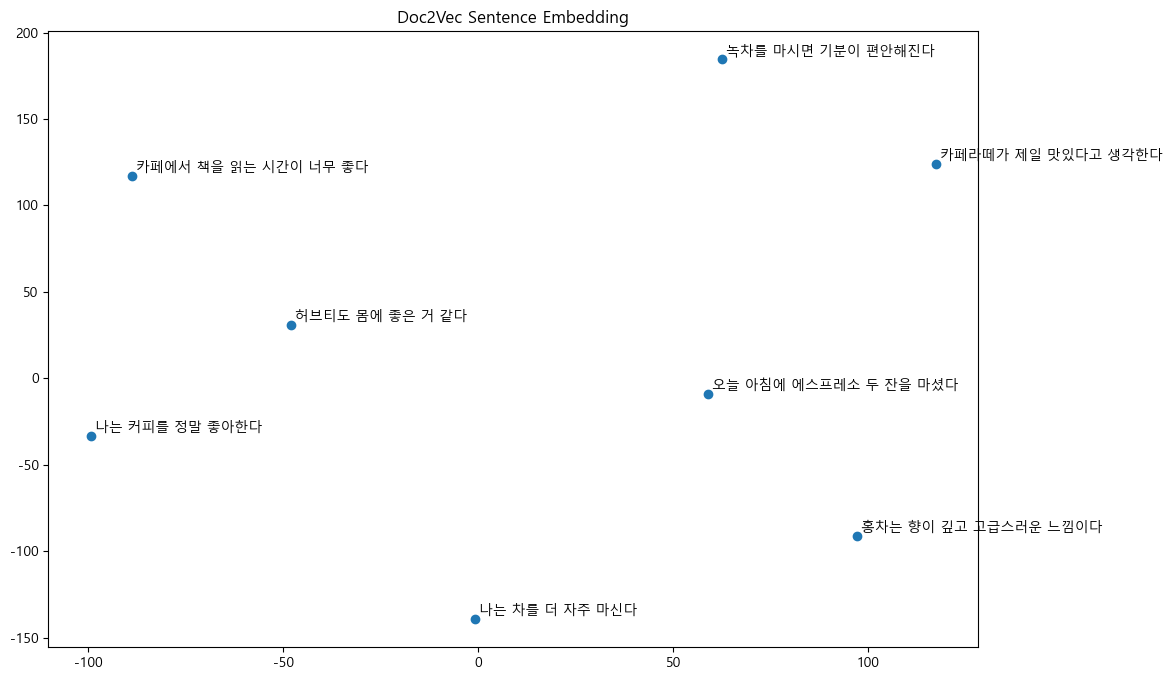

In [ ]:
# 각 점에 주석 추가 (해당 위치의 문장 데이터)
plt.figure(figsize=(12, 8))
# 산점도: plt.scatter(X축 데이터, Y축 데이터)
# X_2d의 첫 번째 열과 두 번째 열
plt.scatter(X_2d[:, 0], X_2d[:, 1])

# 각 점에 문장 데이터를 주석으로 추가
for idx, text in enumerate(docs):
    plt.annotate(
        text,
        xy= (X_2d[idx, 0], X_2d[idx, 1]),   # 원 데이터의 위치
        xytext= (3, 3),                     # 주석의 위치
        textcoords= 'offset points'         # 각각의 위치에 텍스트 대입
    )

plt.title('Doc2Vec Sentence Embedding')
plt.show()

---

In [ ]:
# 문장별 벡터의 값을 이용하여 기계 학습
# 학습 데이터(독립 변수) -> 문장별 벡터 데이터
# 타깃 데이터(종속 변수) -> 커피(1), 차(0)로 데이터 생성
Y = np.array([1, 1, 1, 0, 0, 0, 1, 0])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size= 0.2, random_state= 42
)

clf = LogisticRegression(max_iter= 2000)

In [ ]:
# 모델에 학습
clf.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [ ]:
pred = clf.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



---
## Doc2Vec를 Komoran과 Pytorch를 이용하여 구현

In [6]:
import re, collections
import torch
import torch.nn as nn           # 파이토치의 모델
import torch.optim as optim     # 옵티마이저
from torch.utils.data import Dataset, DataLoader    # 모델에서 사용하기 편한 형태로 데이터의 유형을 변경
from konlpy.tag import Komoran

In [7]:
# 데이터셋은 docs 그대로 사용
docs_raw = docs.copy()
docs_raw

['나는 커피를 정말 좋아한다',
 '오늘 아침에 에스프레소 두 잔을 마셨다',
 '카페라떼가 제일 맛있다고 생각한다',
 '나는 차를 더 자주 마신다',
 '녹차를 마시면 기분이 편안해진다',
 '홍차는 향이 깊고 고급스러운 느낌이다',
 '카페에서 책을 읽는 시간이 너무 좋다',
 '허브티도 몸에 좋은 거 같다']

In [8]:
# 형태소 분석 객체 생성
komoran = Komoran()
# 품사 선택
allow_pos = ['NNP', 'NNG', 'VV', 'VA', 'MAG', 'XR']
# 불용어 처리
stop_word = ['하다', '되다', '이다', '것', '수', '거']

# 문자의 간단한 정규화 함수
def normalize(text):
    text = re.sub( r"[^가-힣0-9a-zA-Z\s\.]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()    # 2칸 이상의 공백을 1칸의 공백으로 변경 + 좌우 공백 제거(strip)
    return text

# 토큰화 함수
def tokenize_komoran(text):
    # 텍스트 정규화
    text = normalize(text)
    tokens = []
    for word, pos in komoran.pos(text):
        if word not in stop_word and len(word) > 1 and pos in allow_pos:
            tokens.append(word)
    return tokens

tokenized_docs = [tokenize_komoran(doc) for doc in docs_raw]
tokenized_docs

[['커피', '정말', '좋아하'],
 ['오늘', '아침', '에스프레소', '마시'],
 ['카페', '제일', '맛있', '생각'],
 ['자주', '마시'],
 ['녹차', '마시', '기분', '편안'],
 ['홍차', '고급', '느낌'],
 ['카페', '시간', '너무'],
 ['허브']]

In [9]:
# 단어 사전 생성
# Doc2Vec의 min_count(단어의 최소 등장 횟수) 만들기
min_count = 1   # 데이터가 적으므로 1로 설정
# 단어들의 출현 횟수를 dict 형태로 생성
freq = collections.Counter(
    word for doc in tokenized_docs for word in doc
    # 2차원 데이터의 원소 하나하나를 뽑아 넣어줌
)
freq

Counter({'마시': 3,
         '카페': 2,
         '커피': 1,
         '정말': 1,
         '좋아하': 1,
         '오늘': 1,
         '아침': 1,
         '에스프레소': 1,
         '제일': 1,
         '맛있': 1,
         '생각': 1,
         '자주': 1,
         '녹차': 1,
         '기분': 1,
         '편안': 1,
         '홍차': 1,
         '고급': 1,
         '느낌': 1,
         '시간': 1,
         '너무': 1,
         '허브': 1})

dict 내장함수
- ```keys( )```, ```values( )```, ...
- ```items( )``` 내장함수를 이용하면 list 안의 tuple 형태로 변경 가능
</br> ```{key:value, key:value, ...}``` $\rightarrow$ ```[ (key, value), (key, value), ... ]```

In [10]:
# 단어 사전 생성
# min_count의 수보다 크거나 같은 경우, 단어 사전에 등록
# 특수 토큰들("<PAD>", "<UNK>" 등)을 포함시킨 단어 사전을 생성
#   "<PAD>": 패딩 (단어별 벡터를 비교하는데 각 문장에서 단어의 개수가 다른 경우, 개수를 맞춰주기 위한 토큰)
#   "<UNK>": 단어 사전에 없는 단어(OOV)를 표기할 때 사용
vocab = ["<PAD>", "<UNK>"] + [ word for word, cnt in freq.items() if cnt >= min_count ]
vocab

['<PAD>',
 '<UNK>',
 '커피',
 '정말',
 '좋아하',
 '오늘',
 '아침',
 '에스프레소',
 '마시',
 '카페',
 '제일',
 '맛있',
 '생각',
 '자주',
 '녹차',
 '기분',
 '편안',
 '홍차',
 '고급',
 '느낌',
 '시간',
 '너무',
 '허브']

In [11]:
word_list = []
# 방법 1
for word, cnt in freq.items():
    # print(word)
    # print(cnt)
    # break
    if cnt >= min_count:
        word_list.append(word)
# 방법 2
# for key in freq:
#     print(key)
#     print(freq[key])
#     break

# 방법 1, 2 둘 다 똑같지만 1이 조금 더 깔끔

In [12]:
# 단어 사전의 단어와 위치 값을 이용한 dict 생성
stoi = {
    word : idx for idx, word in enumerate(vocab)
}
stoi

{'<PAD>': 0,
 '<UNK>': 1,
 '커피': 2,
 '정말': 3,
 '좋아하': 4,
 '오늘': 5,
 '아침': 6,
 '에스프레소': 7,
 '마시': 8,
 '카페': 9,
 '제일': 10,
 '맛있': 11,
 '생각': 12,
 '자주': 13,
 '녹차': 14,
 '기분': 15,
 '편안': 16,
 '홍차': 17,
 '고급': 18,
 '느낌': 19,
 '시간': 20,
 '너무': 21,
 '허브': 22}

In [13]:
# stoi의 데이터를 이용하여, 토큰화된 데이터(tokenized_docs)를 인코딩
def encode(words):
    result = [ stoi.get(word, stoi['<UNK>']) for word in words ]
    return result

encoded_docs = [ encode(doc) for doc in tokenized_docs ]
encoded_docs
# 첫 번째 문장은 인덱스 2번, 3번, 4번 위치의 단어로 이루어짐

[[2, 3, 4],
 [5, 6, 7, 8],
 [9, 10, 11, 12],
 [13, 8],
 [14, 8, 15, 16],
 [17, 18, 19],
 [9, 20, 21],
 [22]]

학습 샘플 생성 (PV-DM, window 기반)
- ```( 문장 ID, [주변 단어 목록], 중심 단어 )```

In [14]:
def build_pvdm_samples(encoded_docs, window = 2):
    # encoded_docs: 인코딩된 무낭 데이터
    samples = []
    for d_id, doc in enumerate(encoded_docs):
        # d_id: index 값 -> 문서의 고유 식별 번호
        # doc: encoded_docs의 각 원소들
        if len(doc) < 2:
            # 중심 단어를 기준으로 주변 단어를 검색하는데, 길이가 1이라면 주변 단어 존재 X
            continue
        # 중심 단어에 따른 주변 단어들을 tuple 형태로 저장해 samples에 추가
        for center in range(len(doc)):
            # center: 중심 단어의 위치
            left = max( 0, center - window )
            right = min( len(doc), center + window + 1 )
            # ctx = [ doc[i] for i in range(left, right) if center != i]
            # ctx: 주변 단어들의 목록
            ctx = []
            for i in range(left, right):
                if i != center:
                    # 중심 단어를 ctx에 포함시키지 않는다.
                    ctx.append(doc[i])
            # ( 문장 ID, [주변 단어 목록], 중심 단어 ) 형태를 samples에 추가
            # ctx가 존재하는 경우에만 추가
            if ctx:
                target = doc[center]
                samples.append( (d_id, ctx, target) )
    return samples

In [15]:
samples = build_pvdm_samples(encoded_docs)
samples

[(0, [3, 4], 2),
 (0, [2, 4], 3),
 (0, [2, 3], 4),
 (1, [6, 7], 5),
 (1, [5, 7, 8], 6),
 (1, [5, 6, 8], 7),
 (1, [6, 7], 8),
 (2, [10, 11], 9),
 (2, [9, 11, 12], 10),
 (2, [9, 10, 12], 11),
 (2, [10, 11], 12),
 (3, [8], 13),
 (3, [13], 8),
 (4, [8, 15], 14),
 (4, [14, 15, 16], 8),
 (4, [14, 8, 16], 15),
 (4, [8, 15], 16),
 (5, [18, 19], 17),
 (5, [17, 19], 18),
 (5, [17, 18], 19),
 (6, [20, 21], 9),
 (6, [9, 21], 20),
 (6, [9, 20], 21)]

In [16]:
# torch에 있는 linear 모델을 사용하기 위해 데이터의 형태를 알맞게 변경
# Dataset, DataLoader
class PVDMDataset(Dataset):
    def __init__(self, samples):
        # class 내부에 독립적인 데이터를 생성
        self.samples = samples
    # DataLoader에서 사용되는 특수 함수 생성
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        d_id, ctx, target = self.samples[idx]
        return d_id, torch.tensor(ctx, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def collate_fn(batch):
    # 문맥에 따라 길이가 다르기 때문에, 리스트를 그대로 전달
    # PAD 토큰은 문맥의 평균을 구해서 작업하기 때문에 필요 없음 (단어의 개수를 맞춰줄 필요가 없음)
    doc_ids, ctx_list, targets = zip(*batch)
    # batch: [ [d_id, ctx, target], [d_id, ctx, target], ... ]
    return torch.tensor(doc_ids, dtype=torch.long), torch.tensor(ctx_list), torch.tensor(targets)

# 데이터셋 구성
dataset = PVDMDataset(samples)
# 데이터로더 생성
loader = DataLoader( dataset, batch_size=64, shuffle=True, collate_fn=collate_fn )

---
예시

In [17]:
# zip 예시
a = [1,2,3,4]
b = [10, 20, 30, 40]
list[zip(a+b)]
# 1차원 리스트가 있으면 각각의 

list[<zip object at 0x00000201A371FF40>]

In [18]:
# * 예시
def func_1(*a):
    print(a)
    return sum(a)

# func_1( [1,2,3,4,5] )     # ([1, 2, 3, 4, 5],)  # TypeError - 리스트 하나가 통째로 첫 번째 원소가 됨
func_1( *[1,2,3,4,5] )      # 하나씩 들어감

(1, 2, 3, 4, 5)


15

In [19]:
def func_2(a, b, c):
    return a+b+c

# func_2( [10, 20, 30] )      # TypeError - 입력 인자 개수 부족
func_2( *[10, 20, 30] )

60

$\Rightarrow$ *batch 라면 batch는 2차원 list나 tuple 형태

---

In [22]:
# 모델의 정의
# PV-DM, 문맥 벡터들의 평균 사용
    # 문서 벡터 + 문맥 벡터들의 평균을 linear 모델에 학습, softmax 기반의 가중치 연산

# nn 안의 Module을 상속받아 사용
class Doc2VecPVDM(nn.Module):
    # 생성자 함수
    # 단어별, 문장별 임베딩 차원 공간 생성
    # 선형 변환층 생성
    def __init__( self, vocab_size, num_docs, emb_dim = 120 ):
        # 부모 클래스에 있는 생성자 함수 실행
        super().__init__()

        # 단어별 임베딩 -> vocab_size, emb_dim 을 이용해 차원 공간 생성
        self.word_emb = nn.Embedding( vocab_size, emb_dim )
        # 문장별 임베딩 -> num_docs, emb_dim 을 이용해 차원 공간 생성
        self.doc_emb = nn.Embedding( num_docs, emb_dim )
        # 단어의 확률 분포를 선형 변환층으로 생성하기 위해 단어/문서 임베딩을 이용
        self.proj = nn.Linear(emb_dim, vocab_size, bias=False)
            # doc2vec의 입력 벡터와 가중치 행렬만을 이용하기 때문에, 절편의 역할인 bias 사용 False
        
        # embedding 값들을 초기화 (자비에르 초기화)
        # 임베딩 행렬의 초기값을 적당한 분포로 설정하여, 학습이 잘 되도록 초기화
        self._init_weight()
    
    # 자비에르 초기화 함수 생성
    def _init_weight(self):
        nn.init.xavier_uniform_(self.word_emb.weight)
        nn.init.xavier_uniform_(self.doc_emb.weight)
        nn.init.xavier_uniform_(self.proj.weight)

    def forward(self, doc_ids, ctx_list):
        # doc_ids -> (ids 개수(배치 사이즈), )
        # ctx_list -> ids 개수(배치 사이즈), 각 원소 (주변 단어들의 수)
        # pytorch의 장점: GPU 사용 가능
        device = self.word_emb.weight.device    # CPU/GPU 중 설정되어있는 옵션을 사용

        # 문서 임베딩
        # device(CPU/GPU)에서 가져옴
        dvec = self.doc_emb(doc_ids.to(device))

        # 문맥 임베딩의 평균 (dm_mean = 1 인 경우)
        ctx_mean = []
        for ctx in ctx_list:
            ctx = ctx.to(device)
            we = self.word_emb(ctx)
            # we의 평균을 ctx_mean에 추가
            ctx_mean.append( we.mean(dim=0) )
        ctx_mean = torch.stack(ctx_mean, dim= 0)    # stack: tensor에 채워주는 역할 -> 차원 바꿀 때 사용
        # 문서 임베딩과 같은 형태(크기)

        # 단순 평균: (문서 + 문맥) / 2
        mix = (dvec + ctx_mean) / 2.0

        # 혼합된 임베딩 벡터를 Linear에 대입
        logits = self.proj(mix)     # (배치 사이즈, 단어 사전 개수)

        return logits
    
    # Doc2Vec의 핵심 메서드 infer_vector() : 새 문장의 벡터를 추론
    def infer_vector(self, word_ids, epochs = 100, lr = 0.05):      # lr: 경사하강법의 가중치 변화율
        # 새 문장의 벡터 추론
        device = self.word_emb.weight.device

        # 새로운 문장에 대한 정규분포형 난수 벡터를 생성
        # 정규 분포의 확률에 따라서 각 단어 벡터를 만들어준다.
        # 초기값을 0으로 지정하면 학습의 안정성이 떨어짐.
        # self.doc_emb.weight은 이미 정규 분포 근처의 값들로 학습되어 있음.
        # -> 정규분포형 난수 벡터를 사용하면 학습의 안정성, 수렴 속도 증가
        dvec = nn.Parameter( torch.randn(self.doc_emb.embedding_dim, device=device) )

        # 하나의 임시 문장을 이용해 반복 학습할 땐, 단순 경사하강법을 이용해 가중치에 변화를 준다.
        optimizer = optim.SGD([dvec], lr=lr)
        # 손실 함수
        loss_fn = nn.CrossEntropyLoss()

        # 윈도우 기반 간단 학습 샘플
        window = 2
        triples = []
        if len(word_ids) < 2:
            word_ids = word_ids * 2
            for center in range(len(word_ids)):
                left = max(0, center - window)
                right = min(len(word_ids), center + window + 1)
                ctx = [ word_ids[i] for i in range(left, right) if i != center ]
                if ctx:
                    triples.append( (ctx, word_ids[center]) )
                
            # 문서 벡터만 업데이트
            for _ in range(epochs):
                random.shuffle(triples)
                for ctx, target in triples:
                    # 문맥 단어 임베딩의 평균 구하기
                    we = self.word_emb(torch.tensor(ctx, device=device))
                    ctx_mean = we.mean(dim=0)
                    # 단순 평균: (문서 벡터 + 문맥 평균 벡터) / 
                    mix = (dvec + ctx_mean) / 2.0
                    # 중심 단어 예측을 통한 학습
                    logits = self.proj(mix)
                    loss = loss_fn( logits.unsqueeze(0), torch.tensor([target], device=device) )

                    # 기울기 초기화
                    optimizer.zero_grad()
                    # 백워드 실행
                    loss.backword()
                    # 스텝
                    optimizer.step()
        return dvec.detach().cpu()